In [77]:
import dhlab.nbtext as nb
import dhlab.graph_networkx_louvain as gnl
import dhlab.nbtokenizer as tok
from dhlab.module_update import css, update, code_toggle

In [30]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
%matplotlib inline

In [31]:
def get_df(frases, title='aftenposten'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        #'filter':'mediatype:{mt}'.format(mt=media),
        'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    return {x['key']:x['count'] for x in aggs}

def get_json(frases, mediatype='aviser'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'snippets':mediatype,
        'aggs':'year',
        
#        'filter':'mediatype:{mt}'.format(mt=mediatype),
        'searchType':'FULL_TEXT_SEARCH'
        #'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()
    return aggs

def get_data(frase, media='avis', title='jazznytt'):
    import requests
    query = {
        'q':'"'+frase+'""',
        'size':1,
        'aggs':'year',
        'filter':'mediatype:{mt}'.format(mt=media),
        'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_data_and(frases, title='aftenposten', media='avis'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    print(querystring)
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        #'filter':'mediatype:{mt}'.format(mt=media),
        'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_df_pd(frase, media='bøker'):
    import pandas as pd
    return pd.DataFrame.from_dict(get_df(frase, media=media ), orient='index').sort_index()

In [32]:
def phrase_plots(phrase_sets, title='aftenposten', fra = 1960, til = 2020, step=5, rot=0, colours = ['r', 'b','g','y','m','c']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    df['bins'] = pd.cut(df.index, range(fra, til, step), precision=0)
    df.groupby('bins').sum().plot(kind='bar', color=colours, figsize=(15,5), rot=rot)
    return

def phrase_plots_anno(phrase_sets, title='aftenposten', fra = 1960, til = 2020, rot=0, colours = ['r', 'b','g']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    #df['bins'] = pd.cut(df.index, range(fra, til, step), precision=0)
    df.plot(kind='bar', figsize=(15,5), rot=rot, color=colours)
    return

def graph_from_df(df, threshold = 100):
    edges =  []
    normalizer = {(x, y): df.stack()[(x,x)]*df.stack()[(y,y)] for (x,y) in df.stack().index}
    for (x, y) in df.stack().index:
        if x != y:
            if df.stack()[(x,y)] > threshold:
                edges.append([x,y,df.stack()[(x,y)]/normalizer[(x,y)]])
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

In [86]:
def get_konks(urn, phrase, window=1000, n = 1000):
    import requests
    querystring = '"'+ phrase +'"' 
    query = {
        'q':querystring,
        'fragments': n,
        'fragSize':window
       
    }
    r = requests.get("https://api.nb.no/catalog/v1/items/{urn}/contentfragments".format(urn=urn), params = query)
    res = r.json()
    results = []
    try:
        for x in res['contentFragments']:
            urn = x['pageid']
            hit = x['text']
            splits = hit.split('<em>')
            s2 = splits[1].split('</em>')
            before = splits[0]
            word = s2[0]
            after = s2[1]
            results.append({'urn': urn, 'before': before, 'word':word, 'after':after})
    except:
        True
    return results

In [78]:
results = []
for x in r['contentFragments']:
    urn = x['pageid']
    hit = x['text']
    splits = hit.split('<em>')
    s2 = splits[1].split('</em>')
    before = splits[0]
    word = s2[0]
    after = s2[1]
    results.append({'urn': urn, 'before': before, 'word':word, 'after':after})

In [79]:
results

[{'urn': 'URN:NBN:no-nb_digavis_aftenposten_null_null_20030220_144_86_2-1_037_null',
  'before': 'frakt og montering Oslo 22 80 42 80 ',
  'word': 'Julia,',
  'after': ' den mørkhårede i Tatu, feiret 18- årsdagen sin på russisk vis denne uken: Hun drakk til hun sovnet '},
 {'urn': 'URN:NBN:no-nb_digavis_aftenposten_null_null_20030220_144_86_2-1_037_null',
  'before': 'jentene tok drink etter drink - helt til ',
  'word': 'Julia',
  'after': ' sovnet ved bordet. Korttid etterpå tok også Lena Katina en høneblund. - Det var veldig morsomt da '},
 {'urn': 'URN:NBN:no-nb_digavis_aftenposten_null_null_20030220_144_86_2-1_057_null',
  'before': '30 Spin City. 19.00 Big Brother. 21.00 Alla talar om Grace. Am. komedie fra 1995.1 hovedrollene: ',
  'word': 'Julia',
  'after': ' Roberts, Dennis Quaid og Robert Duvall. Regi: Lasse Hallstrøm. 23.00 Frasier. 23.30 Spin City. 24.00 Big'}]

In [95]:
r = get_konks("URN:NBN:no-nb_digibok_2011021403034", "pølse")
r

[{'urn': 'URN:NBN:no-nb_digibok_2011021403034_0007',
  'before': "pølser mcd vegeta- Mester'n . Budeia . Entusiasten bilsk olje m p åskepø i S er Del 1: ",
  'word': 'Pølse',
  'after': ' eller DVlse? 10 Halalpølse - Kyllingpølser _, ...... .. .. , . . . .Kalkunpølser. Kylling-'},
 {'urn': 'URN:NBN:no-nb_digibok_2011021403034_0007',
  'before': 'gjort av deg? 18 «Leverpostei, fleskepølser Om norske pølsemakere, °9 blodpølser . Spekepølser pølsegastronomer, ',
  'word': 'pølse-',
  'after': ' «Jr-øiser aviaKsr venner, pølseskeptikere Del 3: Å lage pylser .. . É^ Een lille pølseordboka 42'},
 {'urn': 'URN:NBN:no-nb_digibok_2011021403034_0009',
  'before': 'det gjør vi jo alle pølser: En enslig mann på en bensinstasjon tre! ved middagstider, med ei ',
  'word': 'pølse',
  'after': ' i handa, bryter god spiseskikk. Pølsa blir da for mange et symbol på forfall. Vi har ikke'},
 {'urn': 'URN:NBN:no-nb_digibok_2011021403034_0014',
  'before': 'fjøllbygd so kling Er produksjonen under kontroll 

In [93]:
nb.book_corpus(period=(2005,2020))

,urn,author,title,year
0,2013071706036,,Hånda i været,2008
1,2012072338020,"Holøs, Sverre Bjørn",Vedlikehold,2005
2,2013022638017,,Norges store gjør det selv-leksikon,2007
3,2012120408106,,Kommuner bryter loven ved henvendelser om økon...,2011
4,2013112808199,"Anderberg, Ulla Maria",Fibromyalgi,2008
5,2016020807526,"Hemgren, Per",Maling og tapetsering,2006
6,2013062406109,"Askland, Leif",Medarbeideren,2007
7,2011071408008,"Johnsen, Geir Helge",Dokumentasjonsvedlegg til søknad om utvidelse ...,2006
8,2011090808080,,EU - miljøets beste kompis!,2007
9,2011021403034,"Jacobsen, Hans-Petter",Den store pølseboka,2008


In [66]:
nb.concordance(word='morsomt', corpus='avis', title='aftenposten', kind="json")

[{'after': '. Når Kristopher Schaus pølsestunt',
  'before': '; de synes medier ev',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word': 'morsomt'},
 {'after': ". Kristoffer Nordvik Ti '",
  'before': 'det etter all sannsynlighet blir',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word': 'morsomt'},
 {'after': 'kurs vil dere få kunnskap',
  'before': 'Gjennom gratis , lærerikt og',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word': 'morsomt'},
 {'after': 'kurs vil dere få kunnskap',
  'before': 'Gjennom gratis , lærerikt og',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word': 'morsomt'},
 {'after': ', innrømmer 18 - åringen',
  'before': ', men det er ikke',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word':

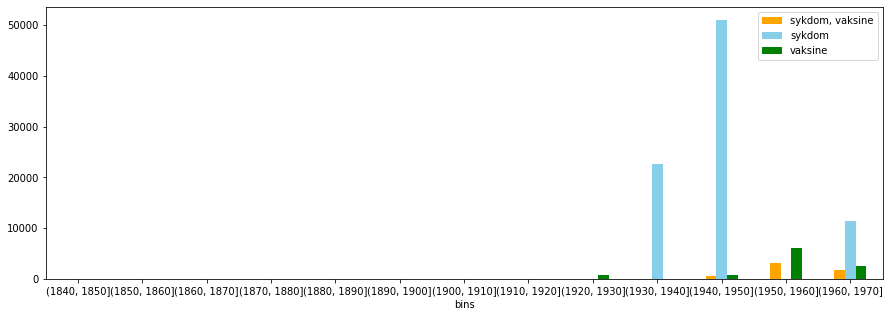

In [44]:
phrase_plots([['sykdom', 'vaksine'],['sykdom'],['vaksine']], title='*', colours=['orange', 'skyblue','green'], fra=1840, til=1980, step=10)

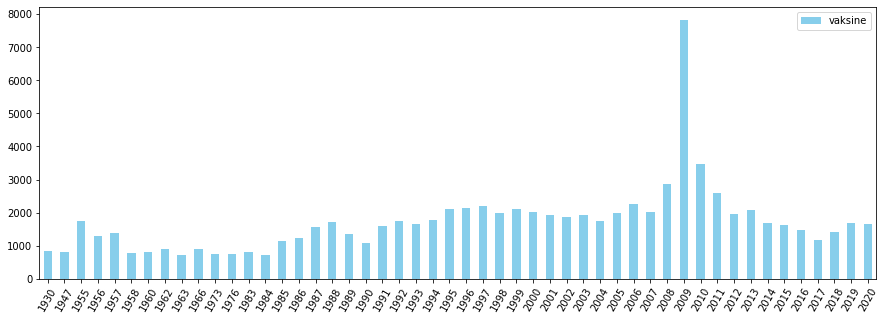

In [45]:
phrase_plots_anno([['vaksine']], title='*', fra=1945, til=2020,  rot=60, colours=['skyblue'])

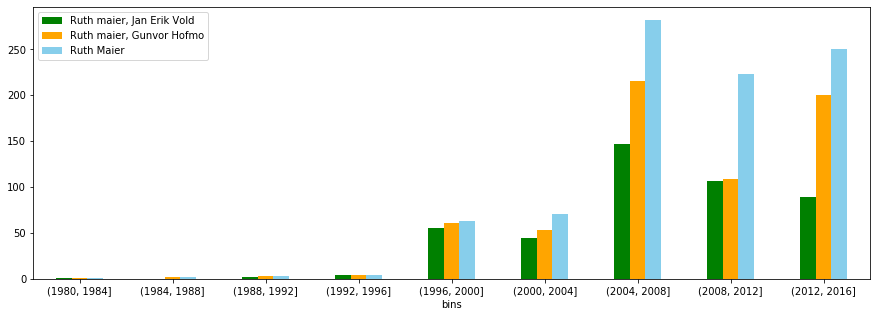

In [36]:
phrase_plots([["Ruth maier", 'Jan Erik Vold'], ['Ruth maier', 'Gunvor Hofmo'],['Ruth Maier']], title='*', colours=['green', 'orange', 'skyblue'], fra=1980, til=2020, step=4)